# Discrete equivalent noise for cts plant

In [6]:
try: 
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2
%run basic_material

from numpy.random import randn
from numpy import eye, array, asarray, exp

from sympy import Matrix, init_printing
init_printing()

from math import sqrt
import scipy.linalg as la
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
from scipy.integrate import odeint

Running Python: 3.8.16


In [14]:
# algorithm for finding discrete noise (see 8-16)
# for a cts A,Bw,Bu
def DiscretizeW(A,Bw,Wc,Bu,dt = 1):
    Nx,_ = A.shape
    # find Ad and Wd
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = Bw@np.atleast_2d(Wc)@Bw.T
    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Wd = Ad@CC[0:Nx,Nx:2*Nx]

    # now find Bd
    _,Nu = Bu.shape
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]
    return Wd, Ad, Bd 

In [15]:
x0 = np.array([[1], [0]]) # initial condition
A = np.array([[0, 1],[-1, -0.7]]) # cts A matrix
Nx = A.shape[0]
Bw = np.array([[0],[1]]) # cts noise input matrix
Wc = np.array([0.015]) # cts noise input matrix
Q0 = np.array([[0.1, 0],[0, 0.01]]) # cts A matrix
tf = 45 # final time
Ts = 2*np.pi/64 # pick some weird time diff
t = np.arange(0,tf,Ts)
Npts = len(t)

Wd, Ad, Bd = DiscretizeW(A,Bw,Wc,Bw,Ts) # convert to discrete

Steady state Q


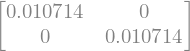

Iterated Steady state Q


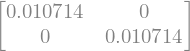

In [16]:
# Steady State value (see Lecture 8)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_discrete_lyapunov.html#scipy.linalg.solve_discrete_lyapunov
Qdss = solve_discrete_lyapunov(Ad, Wd)
print("Steady state Q")
display(Matrix(np.round(Qdss,6)))

# Discrete Prop (see Lecture 8) and sim
Qd = np.zeros((Nx,Nx,Npts+1))
Qd[:,:,0] = Q0
for ii in enumerate(t,start = 1):
    Qd[:,:,ii[0]] = Ad@Qd[:,:,ii[0]-1]@Ad.T+Wd
print("Iterated Steady state Q")
display(Matrix(np.round(Qd[:,:,-1],6)))

In [17]:
x = copy.deepcopy(x0) # mean
xn = x + sqrtm(Q0)@randn(2,1) # IC with noise
wd = sqrtm(Wd)@randn(2,Npts)

In [18]:
Xn = []
X = []
# x are the mean states, xn are the noisy states
for ii in enumerate(t, start = 0):
    Xn = np.append(Xn,xn)
    X = np.append(X,x)
    xn = Ad@xn + wd[:,ii[0]].reshape(2,1)
    x = Ad@x

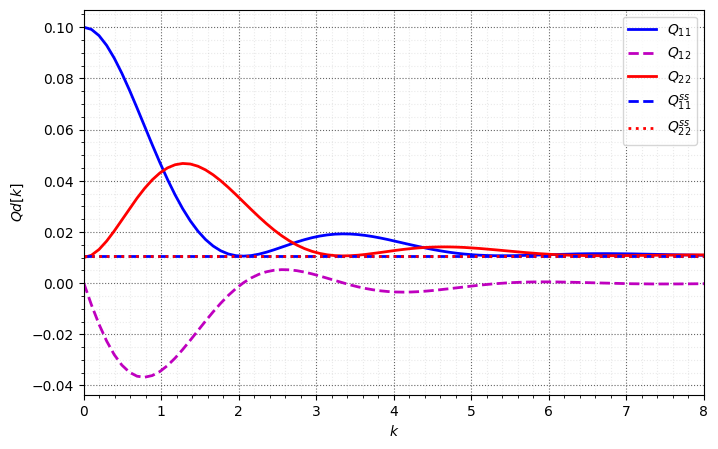

In [20]:
plt.figure(3,figsize=(8,5))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(t,Qd[0,0,:-1],'b',label=r'$Q_{11}$')
ax1.plot(t,Qd[0,1,:-1],'m--',label=r'$Q_{12}$')
ax1.plot(t,Qd[1,1,:-1],'r',label=r'$Q_{22}$')
ax1.plot([0,tf],[Qdss[0,0],Qdss[0,0]],'b--',label=r'$Q^{ss}_{11}$')
ax1.plot([0,tf],[Qdss[1,1],Qdss[1,1]],'r:',label=r'$Q^{ss}_{22}$')
plt.ylabel(r'$Qd[k]$')
plt.xlabel(r'$k$')
plt.xlim([0,8])
nicegrid()
plt.legend(loc='best')
plt.savefig("figs/Pprop1.png")
plt.show()

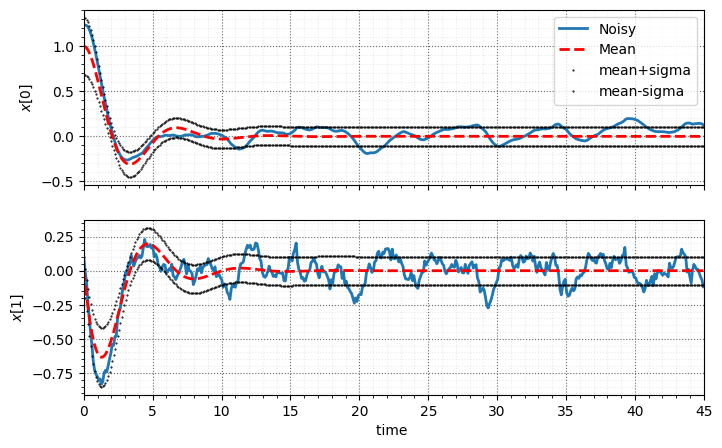

In [21]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8,5))
axs[0].plot(t,Xn[0::2],'-',label='Noisy')
axs[0].plot(t,X[0::2],'r--',label='Mean')
axs[0].plot(t,X[0::2]+np.sqrt(Qd[0,0,:-1]),'k.',ms=1,label=r'mean+sigma')
axs[0].plot(t,X[0::2]-np.sqrt(Qd[0,0,:-1]),'k.',ms=1,label=r'mean-sigma')
axs[1].plot(t,Xn[1::2],'-')
axs[1].plot(t,X[1::2],'r--',label='Mean')
axs[1].plot(t,X[1::2]+np.sqrt(Qd[1,1,:-1]),'k.',ms=1,label=r'mean+sigma')
axs[1].plot(t,X[1::2]-np.sqrt(Qd[1,1,:-1]),'k.',ms=1,label=r'mean-sigma')
axs[0].set_ylabel(r'$x[0]$')
axs[1].set_ylabel(r'$x[1]$')
plt.xlabel(r'time ')
plt.xlim([0, tf])
nicegrid(axs[0])
nicegrid(axs[1])
axs[0].legend(loc='best')
plt.savefig("figs/Pprop2.png")
plt.show()